In [174]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
from ggplot import *
# for maps
from mapboxgl.utils import *
from mapboxgl.viz import *
import geojson
# for text analysis
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
from inflector import Inflector, English
inf = Inflector(English)

In [2]:
file_path = './camb-pb-data/Participatory_Budgeting_Ideas_Submitted_by_Community_Members.csv'
pb_data = pd.read_csv(file_path)

In [3]:
pb_data.head()

,PB Cycle,Idea #,Committee,Project Title,Project Description,Project Status,Idea Submitter,Location,Latitude,Longitude
0,PB1 (October 2014-April 2015),C1,Culture & Community Facilities,Renovate the O'Connell Library; including the ...,This is needed because the library is a very a...,"This project made it to the ballot, but didn't...",Yan,"48 Sixth Street\n(42.3704669999999, -71.084961)",42.370467,-71.084961
1,PB1 (October 2014-April 2015),C2,Culture & Community Facilities,New furniture for the O'Connell Library,The library needs new furniture and maybe a pl...,"This project made it to the ballot, but didn't...",Keniya,"Otis Street\n(42.3704329999999, -71.0847749999...",42.370433,-71.084775
2,PB1 (October 2014-April 2015),C3,Culture & Community Facilities,Renovate the Cambridge Public Library branches...,"The Main Library is great, but many branches a...",Renovations for the O'Connell Library branch m...,Rena,"45 Pearl Street\n(42.363069, -71.1024699999999)",42.363069,-71.102470
3,PB1 (October 2014-April 2015),C4,Culture & Community Facilities,Main Library improvements,1. Free parking. 2. Paid parking to be longer...,Budget Delegates did not move this idea forwar...,Martha Older,"449 Broadway\n(42.3741209, -71.1107166)",42.374121,-71.110717
4,PB1 (October 2014-April 2015),C5,Culture & Community Facilities,Improvements to all libraries,More computers. Tax forms. Tool check out.,Budget Delegates did not rank this as a high p...,Martha Older,"Citywide\n(42.366956, -71.1058539999999)",42.366956,-71.105854


In [4]:
pb_data['Committee'] = pb_data['Committee'].apply(lambda x: x.strip())

In [5]:
pb_data.groupby('Committee').size()

Committee
'Bridge Builders                   76
Community Resources                96
Culture & Community Facilities    195
Environment                        93
Environment, Health & Safety      212
Health, Environment & Safety      121
Parks & Recreation                300
Parks, Recreation & Education     113
Streets, Sidewalks & Transit      170
Streetsmarts                      582
Youth & Education                  63
Youth & Technology                 58
dtype: int64

In [6]:
def rename_committees(committee):
    # code to rename committees
    if committee == 'Environment' or committee == 'Environment, Health & Safety' or committee == 'Health, Environment & Safety':
        return 'Environment, Health & Safety'
    elif committee == 'Parks & Recreation' or committee == 'Parks, Recreation & Education':
        return 'Parks, Recreation & Education'
    elif committee == 'Youth & Education' or committee == 'Youth & Technology':
        return 'Youth Education & Technology'
    elif committee == 'Streets, Sidewalks & Transit' or committee == 'Streetsmarts':
        return 'Streets, Sidewalks & Transit'
    elif committee == 'Culture & Community Facilities' or committee == 'Community Resources' or committee == '\'Bridge Builders':
        return 'Culture & Community'
    else:
        return committee

In [7]:
pb_data['Committee'] = pb_data['Committee'].apply(rename_committees)

In [8]:
pb_data['Committee'].value_counts(normalize=True)

Streets, Sidewalks & Transit     0.361712
Environment, Health & Safety     0.204906
Parks, Recreation & Education    0.198653
Culture & Community              0.176527
Youth Education & Technology     0.058201
Name: Committee, dtype: float64

In [9]:
committee_groups = pb_data.groupby(['Committee'])
committees = committee_groups.size().to_frame(name='# of ideas submitted').reset_index()
committees.to_csv('camb-pb-data/committees.csv')

In [10]:
committees.head()

,Committee,# of ideas submitted
0,Culture & Community,367
1,"Environment, Health & Safety",426
2,"Parks, Recreation & Education",413
3,"Streets, Sidewalks & Transit",752
4,Youth Education & Technology,121


In [11]:
cycle_groups = pb_data.groupby('PB Cycle')
cycles = cycle_groups.size().to_frame(name="# of ideas submitted").reset_index()
cycles.to_csv('camb-pb-data/cycles.csv')

In [12]:
cycles.head()

,PB Cycle,# of ideas submitted
0,PB1 (October 2014-April 2015),380
1,PB2 (June-December 2015),540
2,PB3(June-December 2016),549
3,PB4(June-December 2017),610


In [13]:
pb_data.head()

,PB Cycle,Idea #,Committee,Project Title,Project Description,Project Status,Idea Submitter,Location,Latitude,Longitude
0,PB1 (October 2014-April 2015),C1,Culture & Community,Renovate the O'Connell Library; including the ...,This is needed because the library is a very a...,"This project made it to the ballot, but didn't...",Yan,"48 Sixth Street\n(42.3704669999999, -71.084961)",42.370467,-71.084961
1,PB1 (October 2014-April 2015),C2,Culture & Community,New furniture for the O'Connell Library,The library needs new furniture and maybe a pl...,"This project made it to the ballot, but didn't...",Keniya,"Otis Street\n(42.3704329999999, -71.0847749999...",42.370433,-71.084775
2,PB1 (October 2014-April 2015),C3,Culture & Community,Renovate the Cambridge Public Library branches...,"The Main Library is great, but many branches a...",Renovations for the O'Connell Library branch m...,Rena,"45 Pearl Street\n(42.363069, -71.1024699999999)",42.363069,-71.102470
3,PB1 (October 2014-April 2015),C4,Culture & Community,Main Library improvements,1. Free parking. 2. Paid parking to be longer...,Budget Delegates did not move this idea forwar...,Martha Older,"449 Broadway\n(42.3741209, -71.1107166)",42.374121,-71.110717
4,PB1 (October 2014-April 2015),C5,Culture & Community,Improvements to all libraries,More computers. Tax forms. Tool check out.,Budget Delegates did not rank this as a high p...,Martha Older,"Citywide\n(42.366956, -71.1058539999999)",42.366956,-71.105854


In [14]:
pb_by_category = committee_groups.size().to_frame(name='# of ideas').reset_index()

In [15]:
pb_by_location = pb_data.dropna(axis=0, how='any', subset=['Latitude', 'Longitude'])

In [16]:
# ideas by location
df_to_geojson(pb_by_location, filename='camb-pb-data/locations.geojson',
              properties=['Committee', 'PB Cycle'],
              lat='Latitude', lon='Longitude', precision=3)

/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/mapboxgl/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[lon] = df[lon].round(precision)
/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/mapboxgl/utils.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[lat] = df[lat].round(precision)


{'feature_count': 1514,
 'filename': 'camb-pb-data/locations.geojson',
 'type': 'file'}

In [17]:
pb_data['Idea Submitter'].value_counts().head()

Martha Older                   69
Anonymous                      30
Russell Youth Center           29
PB Assembly                    23
CHA Summer Literacy Program    23
Name: Idea Submitter, dtype: int64

Things I am interested in finding out:
- categorize the ideas based on their content, more specific categories, rather than the few we have
- break the interest of particular types of ideas (by category and the above) by year, see if trends exist for particular types of ideas
- look at the influence of the minority, 69 (3.5% total) ideas presumably came from one person, that's a lot of influence (calculate how much based on any accepted proposals)

In [20]:
committee_and_cycle_groups = pb_data.groupby(['Committee', 'PB Cycle'])
committees_and_cycles = committee_and_cycle_groups.size().to_frame(name='# of ideas submitted').reset_index()
committees_and_cycles.to_csv('camb-pb-data/committees_and_cycles.csv')

In [200]:
committees_and_cycles.head()

,Committee,PB Cycle,# of ideas submitted
0,Culture & Community,PB1 (October 2014-April 2015),80
1,Culture & Community,PB2 (June-December 2015),115
2,Culture & Community,PB3(June-December 2016),76
3,Culture & Community,PB4(June-December 2017),96
4,"Environment, Health & Safety",PB1 (October 2014-April 2015),70


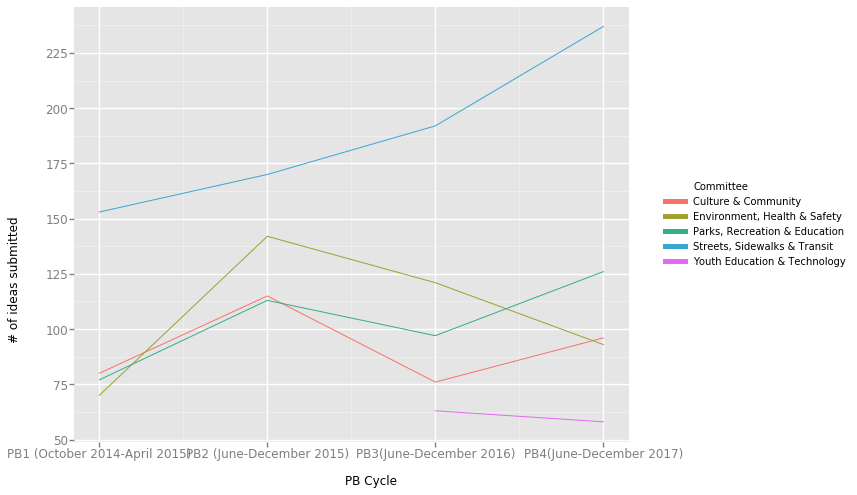

<ggplot: (295723924)>

In [26]:
ggplot(committees_and_cycles, aes(x='PB Cycle', y='# of ideas submitted', colour='Committee')) + geom_line()

In [28]:
# Instantiates a client
client = language.LanguageServiceClient()

In [48]:
def entities_text(text):
    # Instantiates a plain text document.
    document = types.Document(
        content=text,
        type=enums.Document.Type.PLAIN_TEXT)

    # Detects entities in the document. You can also analyze HTML with:
    #   document.type == enums.Document.Type.HTML
    entities = client.analyze_entities(document).entities

    # entity types from enums.Entity.Type
    entity_type = ('UNKNOWN', 'PERSON', 'LOCATION', 'ORGANIZATION',
                   'EVENT', 'WORK_OF_ART', 'CONSUMER_GOOD', 'OTHER')

    entity_list = []
    for entity in entities:
        entity_list.append(entity.name)
    
    return ','.join(entity_list)

In [50]:
pb_data['Entities'] = pb_data['Project Title'].apply(entities_text)

In [54]:
pb_data.to_csv('camb-pb-data/pb_data_updated.csv')

In [175]:
# method for returning frequency counts from list
def get_freq_count(list_of_entities):
    word_freq = {}
    for row in list_of_entities:
        word_array = row.split(',')
        for word in word_array:
            word = inf.singularize(word.lower().strip())
            if word in word_freq:
                word_freq[word] = word_freq[word] + 1
            else:
                word_freq[word] = 1
    return word_freq

In [176]:
total_freq_count = get_freq_count(pb_data['Entities'])
total_words_array = list(total_freq_count.keys())
total_word_counts_array = list(total_freq_count.values())

In [177]:
word_usage_df = pd.DataFrame.from_dict({'Word': total_words_array, 'Count': total_word_counts_array})
word_usage_df.to_csv('camb-pb-data/word_freq.csv')

In [178]:
total_freq_count_by_cycle = {}
for name, group in cycle_groups:
    total_freq_count_by_cycle[name] = get_freq_count(group['Entities'])

In [191]:
pb1_total_freq_count = total_freq_count_by_cycle['PB1 (October 2014-April 2015)']
pb1_total_words_array = list(pb1_total_freq_count.keys())
pb1_total_word_counts_array = list(pb1_total_freq_count.values())

In [192]:
pb1_word_usage_df = pd.DataFrame.from_dict({'Word': pb1_total_words_array, 'Count': pb1_total_word_counts_array})
pb1_word_usage_df.to_csv('camb-pb-data/word_freq_pb1.csv')

In [194]:
pb2_total_freq_count = total_freq_count_by_cycle['PB2 (June-December 2015)']
pb2_total_words_array = list(pb2_total_freq_count.keys())
pb2_total_word_counts_array = list(pb2_total_freq_count.values())

In [195]:
pb2_word_usage_df = pd.DataFrame.from_dict({'Word': pb2_total_words_array, 'Count': pb2_total_word_counts_array})
pb2_word_usage_df.to_csv('camb-pb-data/word_freq_pb2.csv')

In [196]:
pb3_total_freq_count = total_freq_count_by_cycle['PB3(June-December 2016)']
pb3_total_words_array = list(pb3_total_freq_count.keys())
pb3_total_word_counts_array = list(pb3_total_freq_count.values())

In [197]:
pb3_word_usage_df = pd.DataFrame.from_dict({'Word': pb3_total_words_array, 'Count': pb3_total_word_counts_array})
pb3_word_usage_df.to_csv('camb-pb-data/word_freq_pb3.csv')

In [198]:
pb4_total_freq_count = total_freq_count_by_cycle['PB4(June-December 2017)']
pb4_total_words_array = list(pb4_total_freq_count.keys())
pb4_total_word_counts_array = list(pb4_total_freq_count.values())

In [199]:
pb4_word_usage_df = pd.DataFrame.from_dict({'Word': pb4_total_words_array, 'Count': pb4_total_word_counts_array})
pb4_word_usage_df.to_csv('camb-pb-data/word_freq_pb4.csv')

In [218]:
pb1_trends = pb1_word_usage_df[(pb1_word_usage_df['Word'] == 'wifi') | (pb1_word_usage_df['Word'] == 'bike lane') | (pb1_word_usage_df['Word'] == 'bench') | (pb1_word_usage_df['Word'] == 'parking') | (pb1_word_usage_df['Word'] == 'housing')]
pb1_trends['PB Cycle'] = 'PB1 (Oct\'14-Apr\'15)'

/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [220]:
pb2_trends = pb2_word_usage_df[(pb2_word_usage_df['Word'] == 'wifi') | (pb2_word_usage_df['Word'] == 'bike lane') | (pb2_word_usage_df['Word'] == 'bench') | (pb2_word_usage_df['Word'] == 'parking') | (pb2_word_usage_df['Word'] == 'housing')]
pb2_trends['PB Cycle'] = 'PB2 (Jun\-Dec\'15)'

/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [221]:
pb3_trends = pb3_word_usage_df[(pb3_word_usage_df['Word'] == 'wifi') | (pb3_word_usage_df['Word'] == 'bike lane') | (pb3_word_usage_df['Word'] == 'bench') | (pb3_word_usage_df['Word'] == 'parking') | (pb3_word_usage_df['Word'] == 'housing')]
pb3_trends['PB Cycle'] = 'PB3 (Jun\-Dec\'16)'

/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [222]:
pb4_trends = pb4_word_usage_df[(pb4_word_usage_df['Word'] == 'wifi') | (pb4_word_usage_df['Word'] == 'bike lane') | (pb4_word_usage_df['Word'] == 'bench') | (pb4_word_usage_df['Word'] == 'parking') | (pb4_word_usage_df['Word'] == 'housing')]
pb4_trends['PB Cycle'] = 'PB4 (Jun\-Dec\'17)'

/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [228]:
pb_trends = pd.concat([pb1_trends, pb2_trends, pb3_trends, pb4_trends])
pb_trends = pb_trends.rename(columns={"Word": "Topic"})

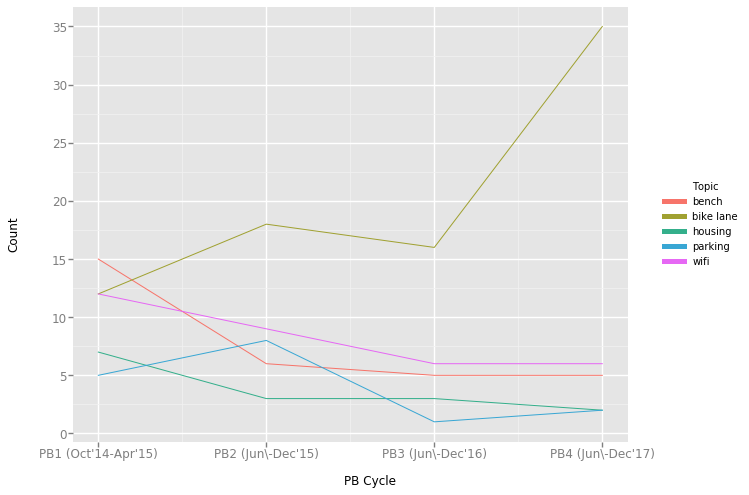

<ggplot: (-9223372029302743587)>

In [229]:
ggplot(pb_trends, aes(x='PB Cycle', y='Count', colour='Topic')) + geom_line()